### Implemention a simple autoencoder on the MIST dataset (images of handwritten digits)

#### Import the relevant packages and define the device

In [43]:
from torch_snippets import *
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch
import matplotlib.pyplot as plt
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Define the transformation required for the images 

In [44]:
images_tranform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,)),
                                      transforms.Lambda(lambda x: x.to(device))])

#### Define the training and validation dataset

In [45]:
datafolder = 'dataset/'
train_dataset = MNIST(datafolder, train=True, download=True, transform=images_tranform)
valid_dataset = MNIST(datafolder, train=False, download=True, transform=images_tranform)

#### Define the dataloader

In [46]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### Define the network architecture 

In [47]:
class AutoEncoder(nn.Module):

    def __init__(self, latent_dim) :
        super().__init__()

        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
                                    nn.Linear(28*28 , 128),
                                    nn.ReLU(True),
                                    nn.Linear(128, 64), 
                                    nn.ReLU(True),
                                    nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
                                    nn.Linear(latent_dim, 64),
                                    nn.ReLU(True),
                                    nn.Linear(64, 128),
                                    nn.ReLU(True),
                                    nn.Linear(128, 28*28),
                                    nn.Tanh())
    
    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)

        return x


#### Visualize the preceding model

In [48]:
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, (1,1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                    [-1, 3]             195
            Linear-6                   [-1, 64]             256
              ReLU-7                   [-1, 64]               0
            Linear-8                  [-1, 128]           8,320
              ReLU-9                  [-1, 128]               0
           Linear-10                  [-1, 784]         101,136
             Tanh-11                  [-1, 784]               0
Total params: 218,643
Trainable params: 218,643
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

### Define the training function

In [49]:
def train_batch(input, model, loss, opimizer):
    model.train()
    opimizer.zero_grad()
    output = model(input)
    loss = loss(output, input)
    loss.backward()
    opimizer.step()
    return loss.item()

#### Define the validation function

In [50]:
@torch.no_grad()
def valid_batch(input, model, loss):
    model.eval()
    output = model(input)
    loss = loss(output, input)
    return loss.item()

#### Define the optimizer and loss function

In [51]:
optimizer  = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn    = nn.MSELoss()

#### Train the models over epochs

In [52]:
num_epoch = 25
log = Report(num_epoch)

for epoch in range(num_epoch):
    N = len(train_dataloader)
    for ix, (data, _) in enumerate(train_dataloader):
        loss = train_batch(data, model, loss_fn, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(valid_dataloader)
    for ix, (data, _) in enumerate(valid_dataloader):
        loss = valid_batch(data, model, loss_fn)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')

    log.report_avgs(epoch+1)

EPOCH: 1.000  val_loss: 0.193  trn_loss: 0.257  (11.72s - 281.33s remaining)
EPOCH: 2.000  val_loss: 0.166  trn_loss: 0.178  (23.49s - 270.11s remaining)
EPOCH: 3.000  val_loss: 0.156  trn_loss: 0.160  (34.60s - 253.74s remaining)
EPOCH: 4.000  val_loss: 0.151  trn_loss: 0.153  (45.98s - 241.37s remaining)
EPOCH: 5.000  val_loss: 0.147  trn_loss: 0.149  (57.68s - 230.72s remaining)
EPOCH: 6.000  val_loss: 0.145  trn_loss: 0.146  (69.26s - 219.31s remaining)
EPOCH: 7.000  val_loss: 0.144  trn_loss: 0.144  (81.11s - 208.57s remaining)
EPOCH: 8.000  val_loss: 0.142  trn_loss: 0.142  (92.45s - 196.46s remaining)
EPOCH: 9.000  val_loss: 0.140  trn_loss: 0.141  (103.97s - 184.83s remaining)
EPOCH: 10.000  val_loss: 0.139  trn_loss: 0.139  (115.78s - 173.68s remaining)
EPOCH: 11.000  val_loss: 0.138  trn_loss: 0.138  (127.41s - 162.16s remaining)
EPOCH: 12.000  val_loss: 0.138  trn_loss: 0.137  (138.91s - 150.49s remaining)
EPOCH: 13.000  val_loss: 0.136  trn_loss: 0.136  (150.05s - 138.50s r

#### Visualize the training and validation loss

100%|██████████| 126/126 [00:00<00:00, 1354.30it/s]


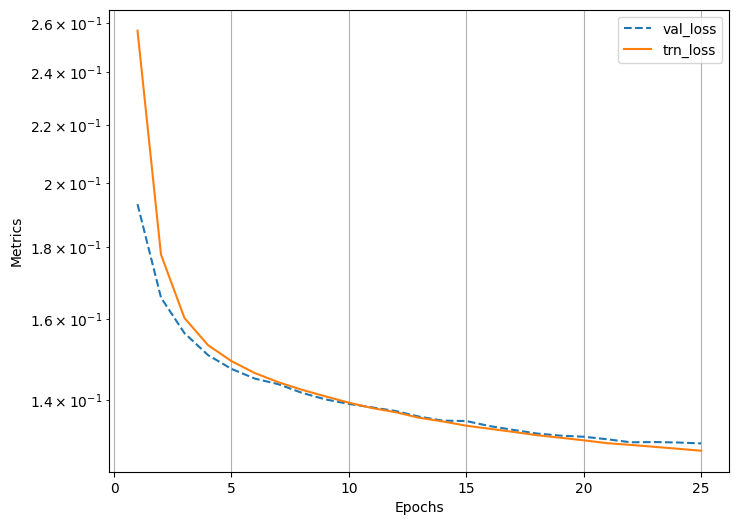

In [55]:
log.plot_epochs(log=True)

#### Validate the model on the validation dataset

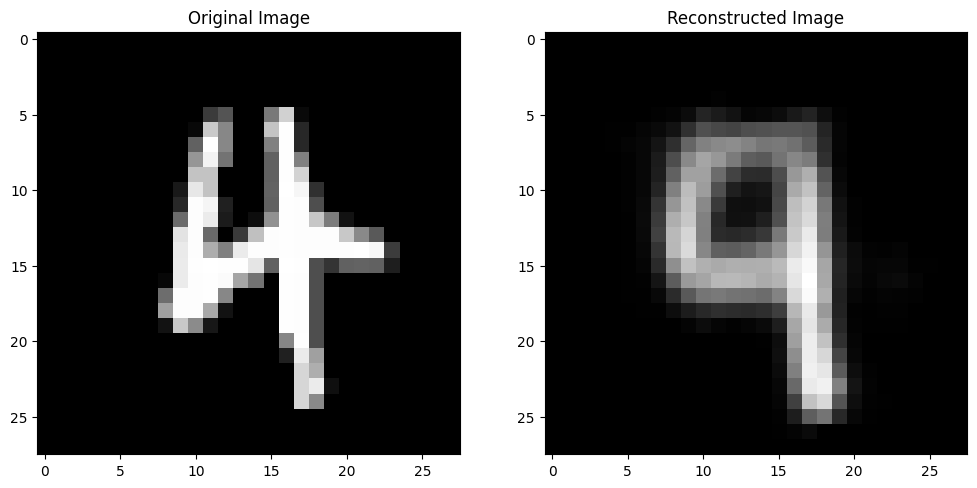

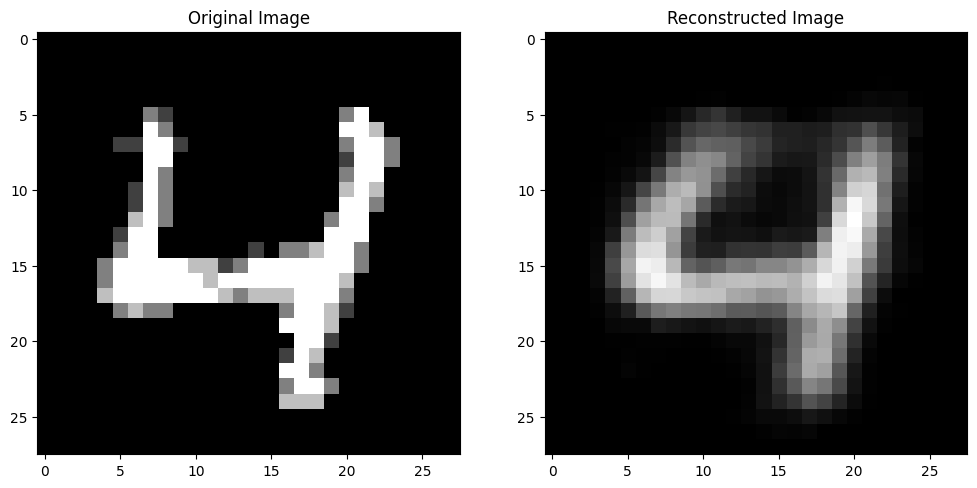

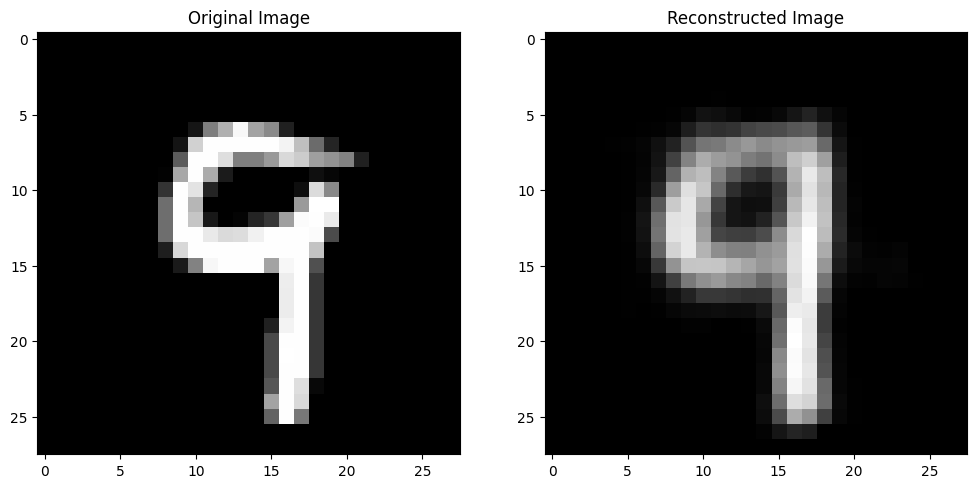

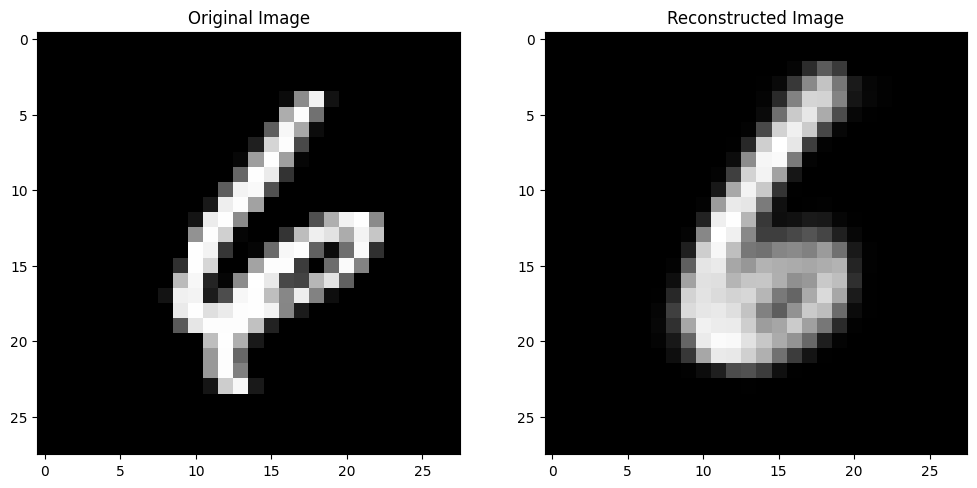

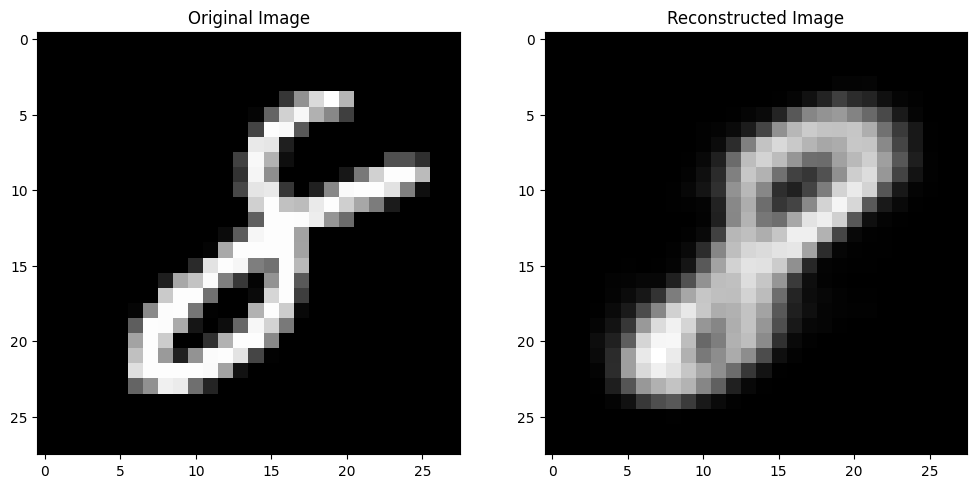

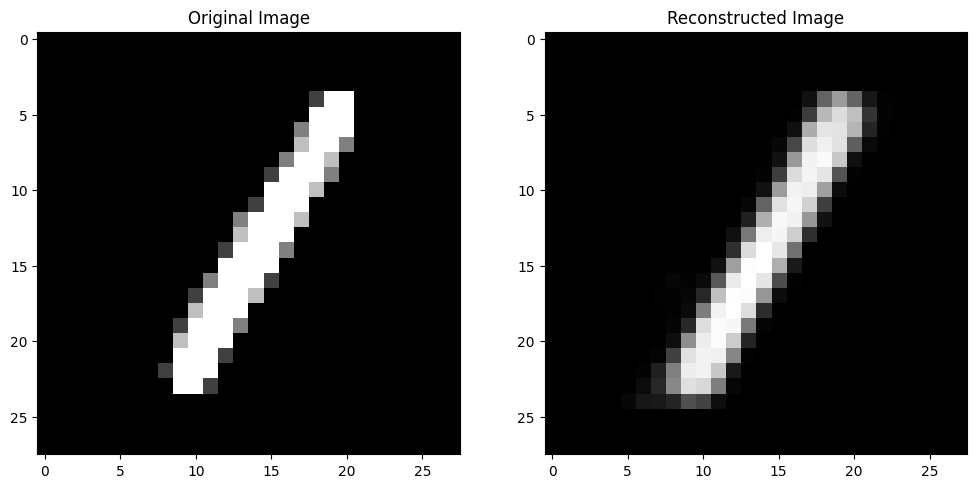

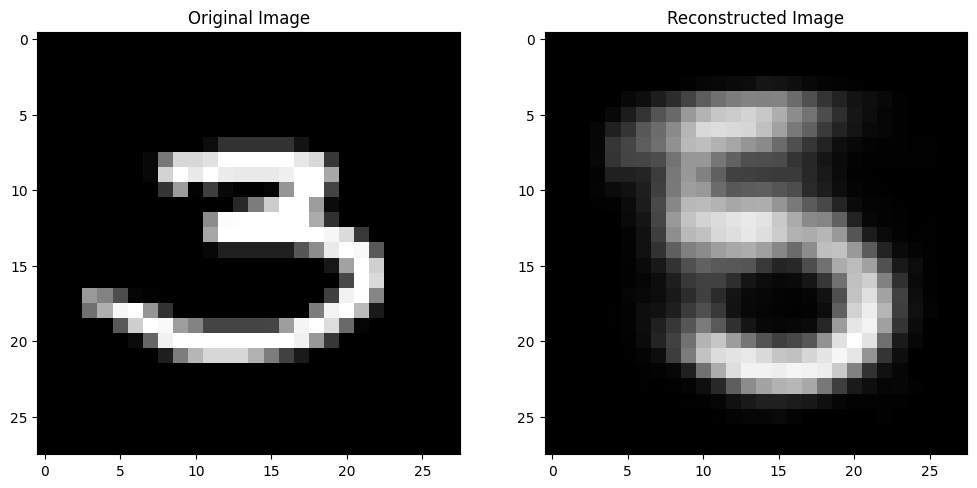

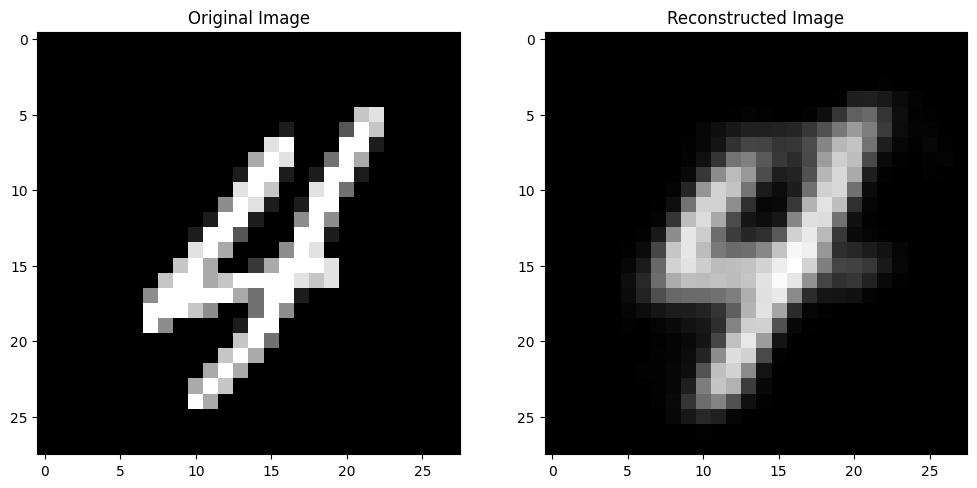

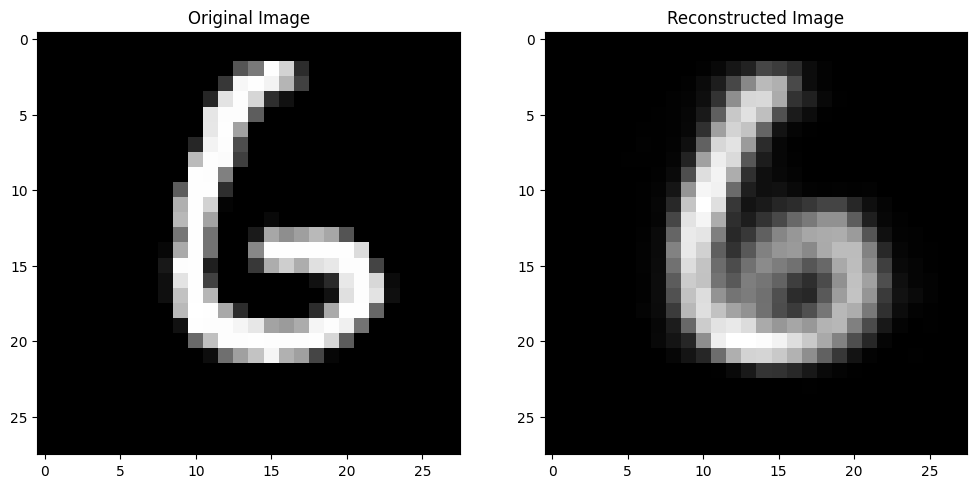

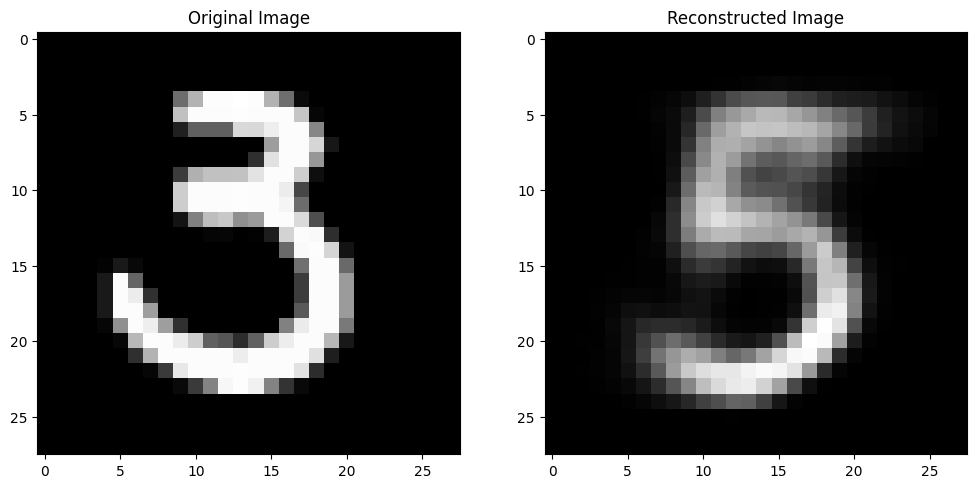

In [56]:
for _ in range (10):
    image_index = np.random.randint(0, len(valid_dataset))
    image,_ = valid_dataset[image_index]
    output_image = model(image)[0]
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0].cpu().detach().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(output_image[0].cpu().detach().numpy(), cmap='gray')
    plt.title('Reconstructed Image')
    plt.show()
    